In [2]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [3]:
# CSVデータの読み込み
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

In [4]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
# データの内容確認
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
9636,-119.5,35.1,34.0,1440.0,309.0,808.0,294.0,2.3,26.6
10554,-120.4,34.6,30.0,2265.0,512.0,1402.0,471.0,2.0,134.0
14448,-122.1,37.7,19.0,3516.0,710.0,1810.0,703.0,3.9,218.0
14885,-122.2,37.4,26.0,440.0,202.0,322.0,218.0,5.2,350.0
14381,-122.1,37.4,22.0,1477.0,195.0,520.0,187.0,10.3,500.0
...,...,...,...,...,...,...,...,...,...
16464,-122.6,38.2,17.0,1728.0,271.0,897.0,284.0,3.5,185.9
16530,-122.7,38.5,21.0,2066.0,393.0,919.0,395.0,3.3,176.2
8889,-118.8,34.3,20.0,3678.0,684.0,1882.0,694.0,4.2,196.8
15478,-122.3,40.7,18.0,2879.0,578.0,1399.0,586.0,2.4,105.4


In [4]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [5]:
# データをシャッフルした後一件のデータを取り出す(SGD)
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [6]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
    """Trains a linear regression model of one feature.
    
    Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        input_feature: A `string` specifying a column from `california_housing_dataframe`
          to use as input feature.
    """
    # 10回学習する
    periods = 10
    steps_per_period = steps / periods
    
    # 説明変数初期化
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]]
    my_label = "median_house_value"
    # 目的変数
    targets = california_housing_dataframe[my_label]

    # 説明変数のカラム生成
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # Create input functions.
    training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
    
    # 線形回帰用のモデルを生成
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
          feature_columns=feature_columns,
          optimizer=my_optimizer
    )

    # 描画用の設定初期化
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    # サンプルデータを300件表示させる
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    # ピリオド毎の学習結果のモデル描画用の色分けに使う
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range (0, periods):
        # モデルを訓練
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # 訓練後に予測をして誤差を取得
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        # scikit-learnで平均二乗誤差を求めた後に平方根を取得
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets))
        # Take a break and compute predictions.

        
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[my_label].max()])
        
        # ピリオド毎で学習した結果のモデルを描画
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
    print("Model training finished.")
    plt.show()

    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    plt.show()

    # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.42
  period 02 : 204.04
  period 03 : 194.97
  period 04 : 186.92
  period 05 : 180.27
  period 06 : 175.00
  period 07 : 171.23
  period 08 : 168.96
  period 09 : 167.30
Model training finished.


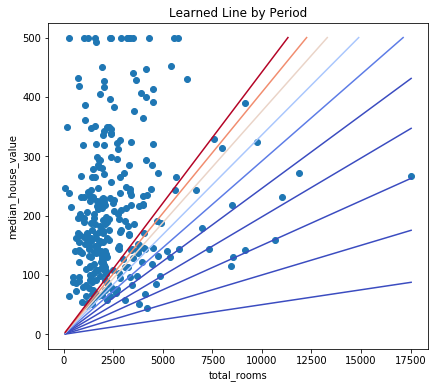

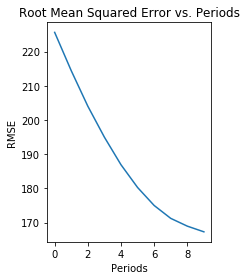

,predictions,targets
count,17000.0,17000.0
mean,116.9,207.3
std,96.4,116.0
min,0.1,15.0
25%,64.6,119.4
50%,94.0,180.4
75%,139.3,265.0
max,1676.8,500.0


Final RMSE (on training data): 167.30


In [7]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

In [15]:
[tf.feature_column.numeric_column("total_rooms")]

[_NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [16]:
[tf.feature_column.numeric_column("total_rooms"), tf.feature_column.numeric_column("median_income")]

[_NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

period:0
Mean Squared Error (on training data): 50907.118
Root Mean Squared Error (on training data): 225.626
period:1
Mean Squared Error (on training data): 45976.242
Root Mean Squared Error (on training data): 214.421
period:2
Mean Squared Error (on training data): 41713.452
Root Mean Squared Error (on training data): 204.239
period:3
Mean Squared Error (on training data): 38224.677
Root Mean Squared Error (on training data): 195.511
period:4
Mean Squared Error (on training data): 35292.536
Root Mean Squared Error (on training data): 187.863
period:5
Mean Squared Error (on training data): 32836.019
Root Mean Squared Error (on training data): 181.207
period:6
Mean Squared Error (on training data): 31131.844
Root Mean Squared Error (on training data): 176.442
period:7
Mean Squared Error (on training data): 29582.200
Root Mean Squared Error (on training data): 171.995
period:8
Mean Squared Error (on training data): 28609.730
Root Mean Squared Error (on training data): 169.144
period:9
M

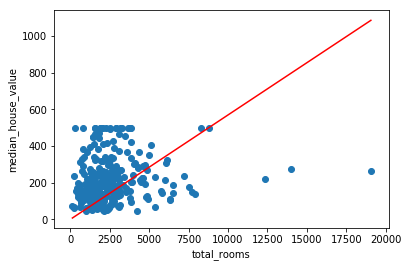

In [8]:
my_feature = california_housing_dataframe[["total_rooms"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms")]
targets = california_housing_dataframe["median_house_value"]

# optimizerはパラメータの更新に使う設定
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.00001)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
for i in range(15):
    _ = linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets),
        steps=100
    )
    prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    # 教師データ、テストデータそれぞれで誤差を算出
    mean_squared_error = metrics.mean_squared_error(predictions, targets)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    print("period:" + str(i))
    print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
    print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)
sample = california_housing_dataframe.sample(n=300)
# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()
# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')
# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# 訓練したモデルと実際のデータを描画
plt.show()
# 学習率がちょうど良いと安定して進む

period:0
Mean Squared Error (on training data): 34937.622
Root Mean Squared Error (on training data): 186.916
period:1
Mean Squared Error (on training data): 28284.453
Root Mean Squared Error (on training data): 168.180
period:2
Mean Squared Error (on training data): 27964.708
Root Mean Squared Error (on training data): 167.227
period:3
Mean Squared Error (on training data): 30027.212
Root Mean Squared Error (on training data): 173.284
period:4
Mean Squared Error (on training data): 32498.327
Root Mean Squared Error (on training data): 180.273
period:5
Mean Squared Error (on training data): 34089.010
Root Mean Squared Error (on training data): 184.632
period:6
Mean Squared Error (on training data): 36156.170
Root Mean Squared Error (on training data): 190.148
period:7
Mean Squared Error (on training data): 37671.223
Root Mean Squared Error (on training data): 194.091
period:8
Mean Squared Error (on training data): 39016.481
Root Mean Squared Error (on training data): 197.526
period:9
M

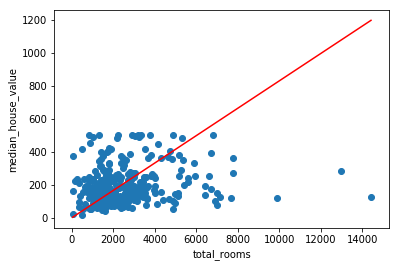

In [34]:
my_feature = california_housing_dataframe[["total_rooms"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms")]
targets = california_housing_dataframe["median_house_value"]

# optimizerはパラメータの更新に使う設定
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.00001)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
for i in range(10):
    _ = linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets),
        steps=500
    )
    prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    # 教師データ、テストデータそれぞれで誤差を算出
    mean_squared_error = metrics.mean_squared_error(predictions, targets)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    print("period:" + str(i))
    print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
    print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)
sample = california_housing_dataframe.sample(n=300)
# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()
# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')
# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# 訓練したモデルと実際のデータを描画
plt.show()
# 学習率がちょうど良いと安定して進む

period:0
Mean Squared Error (on training data): 37216.050
Root Mean Squared Error (on training data): 192.915
period:1
Mean Squared Error (on training data): 32689.207
Root Mean Squared Error (on training data): 180.802
period:2
Mean Squared Error (on training data): 30318.855
Root Mean Squared Error (on training data): 174.123
period:3
Mean Squared Error (on training data): 29006.233
Root Mean Squared Error (on training data): 170.312
period:4
Mean Squared Error (on training data): 28264.359
Root Mean Squared Error (on training data): 168.120
period:5
Mean Squared Error (on training data): 27880.010
Root Mean Squared Error (on training data): 166.973
period:6
Mean Squared Error (on training data): 27698.261
Root Mean Squared Error (on training data): 166.428
period:7
Mean Squared Error (on training data): 27656.937
Root Mean Squared Error (on training data): 166.304
period:8
Mean Squared Error (on training data): 27709.882
Root Mean Squared Error (on training data): 166.463
period:9
M

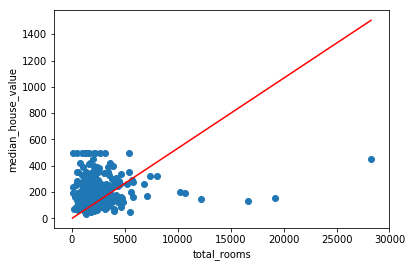

In [33]:
my_feature = california_housing_dataframe[["total_rooms"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms")]
targets = california_housing_dataframe["median_house_value"]

# optimizerはパラメータの更新に使う設定
# Use gradient descent as the optimizer for training the model.
# my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.00001)
my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.0005,initial_accumulator_value=0.01,)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
for i in range(10):
    _ = linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets),
        steps=500
    )
    prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    # 教師データ、テストデータそれぞれで誤差を算出
    mean_squared_error = metrics.mean_squared_error(predictions, targets)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    print("period:" + str(i))
    print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
    print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)
sample = california_housing_dataframe.sample(n=300)
# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()
# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')
# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# 訓練したモデルと実際のデータを描画
plt.show()
# 学習率がちょうど良いと安定して進む

In [17]:
my_feature = california_housing_dataframe[["total_rooms", "median_income"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms"), tf.feature_column.numeric_column("median_income")]
targets = california_housing_dataframe["median_house_value"]


# optimizerはパラメータの更新に使う設定
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.00001)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
for i in range(15):
    _ = linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets),
        steps=100
    )
    prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    # 教師データ、テストデータそれぞれで誤差を算出
    mean_squared_error = metrics.mean_squared_error(predictions, targets)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    print("period:" + str(i))
    print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
    print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

period:0
Mean Squared Error (on training data): 50907.229
Root Mean Squared Error (on training data): 225.626
period:1
Mean Squared Error (on training data): 45976.264
Root Mean Squared Error (on training data): 214.421
period:2
Mean Squared Error (on training data): 41876.413
Root Mean Squared Error (on training data): 204.637
period:3
Mean Squared Error (on training data): 38154.569
Root Mean Squared Error (on training data): 195.332
period:4
Mean Squared Error (on training data): 35232.997
Root Mean Squared Error (on training data): 187.705
period:5
Mean Squared Error (on training data): 32836.118
Root Mean Squared Error (on training data): 181.207
period:6
Mean Squared Error (on training data): 31051.617
Root Mean Squared Error (on training data): 176.215
period:7
Mean Squared Error (on training data): 29673.482
Root Mean Squared Error (on training data): 172.260
period:8
Mean Squared Error (on training data): 28809.433
Root Mean Squared Error (on training data): 169.733
period:9
M

In [20]:
my_feature = california_housing_dataframe[["total_rooms", "median_income"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms"), tf.feature_column.numeric_column("median_income")]
targets = california_housing_dataframe["median_house_value"]


# optimizerはパラメータの更新に使う設定
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.000005,)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
for i in range(10):
    _ = linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets),
        steps=500
    )
    prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    # 教師データ、テストデータそれぞれで誤差を算出
    mean_squared_error = metrics.mean_squared_error(predictions, targets)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    print("period:" + str(i))
    print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
    print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

period:0
Mean Squared Error (on training data): 43774.363
Root Mean Squared Error (on training data): 209.223
period:1
Mean Squared Error (on training data): 35143.560
Root Mean Squared Error (on training data): 187.466
period:2
Mean Squared Error (on training data): 30178.244
Root Mean Squared Error (on training data): 173.719
period:3
Mean Squared Error (on training data): 28067.563
Root Mean Squared Error (on training data): 167.534
period:4
Mean Squared Error (on training data): 27661.914
Root Mean Squared Error (on training data): 166.319
period:5
Mean Squared Error (on training data): 28074.682
Root Mean Squared Error (on training data): 167.555
period:6
Mean Squared Error (on training data): 29003.261
Root Mean Squared Error (on training data): 170.303
period:7
Mean Squared Error (on training data): 30042.989
Root Mean Squared Error (on training data): 173.329
period:8
Mean Squared Error (on training data): 31031.840
Root Mean Squared Error (on training data): 176.159
period:9
M

In [21]:
my_feature = california_housing_dataframe[["total_rooms", "median_income", "total_bedrooms"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms"), tf.feature_column.numeric_column("median_income"), tf.feature_column.numeric_column("total_bedrooms")]
targets = california_housing_dataframe["median_house_value"]


# optimizerはパラメータの更新に使う設定
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.00002,)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
for i in range(10):
    _ = linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets),
        steps=500
    )
    prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    # 教師データ、テストデータそれぞれで誤差を算出
    mean_squared_error = metrics.mean_squared_error(predictions, targets)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    print("period:" + str(i))
    print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
    print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

period:0
Mean Squared Error (on training data): 28247.589
Root Mean Squared Error (on training data): 168.070
period:1
Mean Squared Error (on training data): 30112.544
Root Mean Squared Error (on training data): 173.530
period:2
Mean Squared Error (on training data): 33971.494
Root Mean Squared Error (on training data): 184.314
period:3
Mean Squared Error (on training data): 37588.403
Root Mean Squared Error (on training data): 193.877
period:4
Mean Squared Error (on training data): 37856.436
Root Mean Squared Error (on training data): 194.567
period:5
Mean Squared Error (on training data): 38261.359
Root Mean Squared Error (on training data): 195.605
period:6
Mean Squared Error (on training data): 39117.299
Root Mean Squared Error (on training data): 197.781
period:7
Mean Squared Error (on training data): 41616.921
Root Mean Squared Error (on training data): 204.002
period:8
Mean Squared Error (on training data): 43112.925
Root Mean Squared Error (on training data): 207.637
period:9
M

In [8]:
my_feature = california_housing_dataframe[["total_rooms", "median_income"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms"), tf.feature_column.numeric_column("median_income")]
targets = california_housing_dataframe["median_house_value"]


# optimizerはパラメータの更新に使う設定
# Use gradient descent as the optimizer for training the model.
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0005,)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
for i in range(10):
    _ = linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets),
        steps=500
    )
    prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    # 教師データ、テストデータそれぞれで誤差を算出
    mean_squared_error = metrics.mean_squared_error(predictions, targets)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    print("period:" + str(i))
    print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
    print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

period:0
Mean Squared Error (on training data): 42441.611
Root Mean Squared Error (on training data): 206.014
period:1
Mean Squared Error (on training data): 35264.325
Root Mean Squared Error (on training data): 187.788
period:2
Mean Squared Error (on training data): 38522.086
Root Mean Squared Error (on training data): 196.270
period:3
Mean Squared Error (on training data): 63698.451
Root Mean Squared Error (on training data): 252.386
period:4
Mean Squared Error (on training data): 57390.924
Root Mean Squared Error (on training data): 239.564
period:5
Mean Squared Error (on training data): 57320.471
Root Mean Squared Error (on training data): 239.417
period:6
Mean Squared Error (on training data): 42164.934
Root Mean Squared Error (on training data): 205.341
period:7
Mean Squared Error (on training data): 46558.398
Root Mean Squared Error (on training data): 215.774
period:8
Mean Squared Error (on training data): 38209.068
Root Mean Squared Error (on training data): 195.471
period:9
M

In [9]:
my_feature = california_housing_dataframe[["total_rooms", "median_income"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms"), tf.feature_column.numeric_column("median_income")]
targets = california_housing_dataframe["median_house_value"]


# AdaGrad
my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.0005,initial_accumulator_value=0.01,)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
for i in range(10):
    _ = linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets),
        steps=500
    )
    prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    # 教師データ、テストデータそれぞれで誤差を算出
    mean_squared_error = metrics.mean_squared_error(predictions, targets)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    print("period:" + str(i))
    print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
    print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

period:0
Mean Squared Error (on training data): 37073.315
Root Mean Squared Error (on training data): 192.544
period:1
Mean Squared Error (on training data): 32312.096
Root Mean Squared Error (on training data): 179.756
period:2
Mean Squared Error (on training data): 30123.440
Root Mean Squared Error (on training data): 173.561
period:3
Mean Squared Error (on training data): 28926.608
Root Mean Squared Error (on training data): 170.078
period:4
Mean Squared Error (on training data): 28210.436
Root Mean Squared Error (on training data): 167.960
period:5
Mean Squared Error (on training data): 27833.080
Root Mean Squared Error (on training data): 166.832
period:6
Mean Squared Error (on training data): 27677.242
Root Mean Squared Error (on training data): 166.365
period:7
Mean Squared Error (on training data): 27643.450
Root Mean Squared Error (on training data): 166.263
period:8
Mean Squared Error (on training data): 27708.330
Root Mean Squared Error (on training data): 166.458
period:9
M

In [17]:
my_feature = california_housing_dataframe[["total_rooms", "median_income"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms"), tf.feature_column.numeric_column("median_income")]
targets = california_housing_dataframe["median_house_value"]


# AdaGrad
my_optimizer=tf.train.MomentumOptimizer(0.000005, 0.1)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
for i in range(10):
    _ = linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets),
        steps=500
    )
    prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    # 教師データ、テストデータそれぞれで誤差を算出
    mean_squared_error = metrics.mean_squared_error(predictions, targets)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    print("period:" + str(i))
    print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
    print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

period:0
Mean Squared Error (on training data): 42596.093
Root Mean Squared Error (on training data): 206.388
period:1
Mean Squared Error (on training data): 33721.853
Root Mean Squared Error (on training data): 183.635
period:2
Mean Squared Error (on training data): 29397.565
Root Mean Squared Error (on training data): 171.457
period:3
Mean Squared Error (on training data): 27785.517
Root Mean Squared Error (on training data): 166.690
period:4
Mean Squared Error (on training data): 27776.296
Root Mean Squared Error (on training data): 166.662
period:5
Mean Squared Error (on training data): 28388.588
Root Mean Squared Error (on training data): 168.489
period:6
Mean Squared Error (on training data): 29443.099
Root Mean Squared Error (on training data): 171.590
period:7
Mean Squared Error (on training data): 30811.646
Root Mean Squared Error (on training data): 175.532
period:8
Mean Squared Error (on training data): 32119.729
Root Mean Squared Error (on training data): 179.220
period:9
M

In [10]:
my_feature = california_housing_dataframe[["total_rooms", "median_income"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms"), tf.feature_column.numeric_column("median_income")]
targets = california_housing_dataframe["median_house_value"]


# AdaGrad
my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.0005,initial_accumulator_value=0.01,)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
for i in range(10):
    _ = linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets),
        steps=1
    )
    prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    # 教師データ、テストデータそれぞれで誤差を算出
    mean_squared_error = metrics.mean_squared_error(predictions, targets)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    print("period:" + str(i))
    print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
    print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

period:0
Mean Squared Error (on training data): 55846.902
Root Mean Squared Error (on training data): 236.319
period:1
Mean Squared Error (on training data): 55441.573
Root Mean Squared Error (on training data): 235.460
period:2
Mean Squared Error (on training data): 55112.767
Root Mean Squared Error (on training data): 234.761
period:3
Mean Squared Error (on training data): 54829.564
Root Mean Squared Error (on training data): 234.157
period:4
Mean Squared Error (on training data): 54577.471
Root Mean Squared Error (on training data): 233.618
period:5
Mean Squared Error (on training data): 54348.215
Root Mean Squared Error (on training data): 233.127
period:6
Mean Squared Error (on training data): 54136.901
Root Mean Squared Error (on training data): 232.673
period:7
Mean Squared Error (on training data): 53940.054
Root Mean Squared Error (on training data): 232.250
period:8
Mean Squared Error (on training data): 53755.134
Root Mean Squared Error (on training data): 231.852
period:9
M

In [11]:
my_feature = california_housing_dataframe[["total_rooms", "median_income"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms"), tf.feature_column.numeric_column("median_income")]
targets = california_housing_dataframe["median_house_value"]


# AdaGrad
my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.0005,initial_accumulator_value=0.01,)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
for i in range(10):
    _ = linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets, batch_size=100),
        steps=1
    )
    prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    # 教師データ、テストデータそれぞれで誤差を算出
    mean_squared_error = metrics.mean_squared_error(predictions, targets)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    print("period:" + str(i))
    print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
    print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

period:0
Mean Squared Error (on training data): 55846.924
Root Mean Squared Error (on training data): 236.320
period:1
Mean Squared Error (on training data): 55441.565
Root Mean Squared Error (on training data): 235.460
period:2
Mean Squared Error (on training data): 55112.735
Root Mean Squared Error (on training data): 234.761
period:3
Mean Squared Error (on training data): 54829.552
Root Mean Squared Error (on training data): 234.157
period:4
Mean Squared Error (on training data): 54577.480
Root Mean Squared Error (on training data): 233.618
period:5
Mean Squared Error (on training data): 54348.380
Root Mean Squared Error (on training data): 233.127
period:6
Mean Squared Error (on training data): 54137.161
Root Mean Squared Error (on training data): 232.674
period:7
Mean Squared Error (on training data): 53940.334
Root Mean Squared Error (on training data): 232.251
period:8
Mean Squared Error (on training data): 53755.433
Root Mean Squared Error (on training data): 231.852
period:9
M

In [12]:
my_feature = california_housing_dataframe[["total_rooms", "median_income"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms"), tf.feature_column.numeric_column("median_income")]
targets = california_housing_dataframe["median_house_value"]


# AdaGrad
my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.0005,initial_accumulator_value=0.01,)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
for i in range(500):
    _ = linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets, batch_size=1),
        steps=1
    )
    if i < 490:
        continue
    prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    # 教師データ、テストデータそれぞれで誤差を算出
    mean_squared_error = metrics.mean_squared_error(predictions, targets)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    print("period:" + str(i))
    print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
    print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

period:490
Mean Squared Error (on training data): 37256.500
Root Mean Squared Error (on training data): 193.019
period:491
Mean Squared Error (on training data): 37241.351
Root Mean Squared Error (on training data): 192.980
period:492
Mean Squared Error (on training data): 37226.230
Root Mean Squared Error (on training data): 192.941
period:493
Mean Squared Error (on training data): 37211.140
Root Mean Squared Error (on training data): 192.902
period:494
Mean Squared Error (on training data): 37196.076
Root Mean Squared Error (on training data): 192.863
period:495
Mean Squared Error (on training data): 37181.033
Root Mean Squared Error (on training data): 192.824
period:496
Mean Squared Error (on training data): 37165.998
Root Mean Squared Error (on training data): 192.785
period:497
Mean Squared Error (on training data): 37151.023
Root Mean Squared Error (on training data): 192.746
period:498
Mean Squared Error (on training data): 37136.076
Root Mean Squared Error (on training data): 

In [31]:
my_feature = california_housing_dataframe[[ "median_income"]]
feature_columns = [tf.feature_column.numeric_column("median_income")]
targets = california_housing_dataframe["median_house_value"]


# AdaGrad
my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0005,)
# 勾配が指定した値以上大きくならないようにする
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)
for i in range(10):
    _ = linear_regressor.train(
        input_fn = lambda:my_input_fn(my_feature, targets),
        steps=500
    )
    prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    # 教師データ、テストデータそれぞれで誤差を算出
    mean_squared_error = metrics.mean_squared_error(predictions, targets)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    print("period:" + str(i))
    print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
    print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

period:0
Mean Squared Error (on training data): 54033.629
Root Mean Squared Error (on training data): 232.451
period:1
Mean Squared Error (on training data): 51703.811
Root Mean Squared Error (on training data): 227.385
period:2
Mean Squared Error (on training data): 49434.133
Root Mean Squared Error (on training data): 222.338
period:3
Mean Squared Error (on training data): 47226.087
Root Mean Squared Error (on training data): 217.316
period:4
Mean Squared Error (on training data): 45081.639
Root Mean Squared Error (on training data): 212.324
period:5
Mean Squared Error (on training data): 42994.907
Root Mean Squared Error (on training data): 207.352
period:6
Mean Squared Error (on training data): 40964.634
Root Mean Squared Error (on training data): 202.397
period:7
Mean Squared Error (on training data): 38993.175
Root Mean Squared Error (on training data): 197.467
period:8
Mean Squared Error (on training data): 37078.530
Root Mean Squared Error (on training data): 192.558
period:9
M